In [1]:
import numpy as np
import time
import scipy.sparse as sparse
import cv2
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
from scipy.sparse.linalg import aslinearoperator as alo
from scipy.linalg import toeplitz

Our goal is to test how to do a 2D convolution with numpy functions, to get a feel how one would implement it with BLAS functions. We end up using sparse matrices to boost performance, dunno if that's within BLAS' capabilities.

### Input

We load a $1000\times 1500$ pixel image to stress test, but eliminate RGB dependence to get a grayscale image. Our kernel is a square Gaussian blur with relatively small dimensions.

In [2]:
su=5
sv=5
image = np.mean(cv2.imread('sharpimage.jpg'),axis=2)
U,V = np.meshgrid(np.arange(int(6*su+1)),np.arange(int(6*sv+1)))
kernel = 1/2/np.pi/np.sqrt(su*sv)*np.exp(-(U-3*su)**2/2/su**2-(V-3*sv)**2/2/sv**2)
kernel= kernel / sum(kernel.reshape(-1))

In [3]:
def tictoc(t=0):
    if t==0:
        return time.time()
    print(time.time()-t)
    return time.time()

### Convolution

We define a convolution by first defining symbol $eta_{ijk}$ as a sparse matrix:
$$\eta(I,J,K)_{ijk}=\delta_{i-j,k}\,,\quad i\in [0,I)\,,\quad j\in [0,J)\,,\quad k\in[0,K)\,,$$
with $(I,J,K)=(v_{image},v_{kernel},v_{image})$ for the vertical direction and likewise for the horizontal direction. First we de the biggest contraction of the symbols with the image -huge, here the sparsity is essential- witch amounts to computig shifted versions of the image. The result is non-sparse and the last contraction with the kernel is heavy.

In [4]:
def eta(I,J,K):
    symbol = np.zeros((I*J,K))
    for ij in range(I*J):
        k = +(ij // J) - (ij % J)
        if k >=0 and k < K :
            symbol[ij,k]=1
    return sparse.csr_matrix(symbol)

def convolution(kernel,image):
    vk,uk = kernel.shape
    vi,ui = image.shape
    image = eta(ui,uk,ui).dot(image.T)
    image = eta(vi,vk,vi).dot(image.T)
    return np.tensordot(kernel,image.reshape((vi,vk,ui,uk)),axes=((0,1),(1,3)))

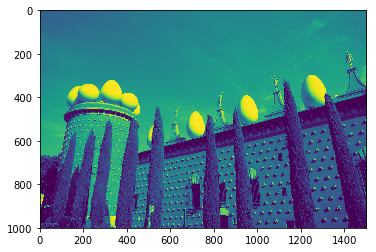

64.79568600654602


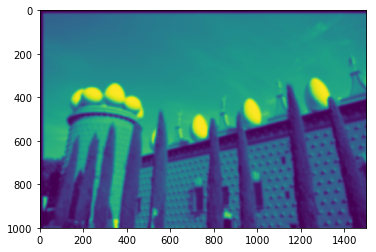

In [5]:
imshow(image)
plt.show()
t=tictoc()
blurred=convolution(kernel,image)
tictoc(t)
imshow(blurred)
plt.show()

### Naive testscripts: Kernel to Sparse Tensor

Test some alternative methods to bring the (sparse) kernel into a tensorcontractible sparse matrix: Naive componentwise implementation, iterative transformation of the kernel, contraction of kernel with symbol, contraction of kernel with sparse symbol. Eventually contracting the (larger) image first, rather than the kernel, was way faster, but this comparison proves that sparse matrices are the way to go.

In [6]:
def conv0(K):
    #naive method
    n=len(K)
    result= np.zeros((n,n,n,n))
    for k in range(n):
        for l in range(n):
            for i in range(n):
                for j in range(n):
                    result[i,j,k,l] = K[i-k,j-l] if ((i-k)>=0 and (j-l)>=0) else 0
    return result

def conv1(K):
    #slightly clever method
    n=len(K)
    a=np.array([[1 if j-i ==-1 else 0 for j in range(n)] for i in range(n)])
    aT=a.T

    halfshiftedkernels=[K]
    hsk = K
    for k in range(n):
        hsk = np.dot(a,hsk)
        halfshiftedkernels += [hsk]
    halfshiftedkernels = np.array(halfshiftedkernels)

    shiftedkernels = [halfshiftedkernels]
    sk= halfshiftedkernels
    for l in range(n):
            sk = np.dot(sk,aT)
            shiftedkernels += [sk]
    return np.transpose(np.array(shiftedkernels),(2,3,1,0))

def conv2(K):
    # cleverder method
    n=len(K)
    hsk=[]
    for k in range(n):
        hsk += [np.diag(np.ones((n-k,)),-k)]
    A = np.array(hsk)
    result = np.dot(np.dot(A,K),A.transpose((0,2,1)))
    return np.transpose(result,(1,3,0,2))        

def conv3(K,out=(0,0)):
    # using sparse matrices
    vk,uk = K.shape
    if any(out)==(0,0):
        vi=vk
        ui=uk
    else:
        (vi,ui)=out
    A = np.zeros((vi*vi,vk))
    for i in range(vi**2):
        k = +(i // vi) - (i % vi)
        if k >=0 and k < vk :
            A[i,k]=1
    B = np.zeros((ui*ui,uk))
    for i in range(ui**2):
        k = +(i // ui) - (i % ui)
        if k >=0 and k < uk :
            B[i,k]=1
    A2 = alo(sparse.kron(sparse.dia_matrix(A),sparse.dia_matrix(B)))
    result=A2.matvec(K.reshape(-1)).reshape((vi,vi,ui,ui))
    return result.transpose((0,2,1,3))

In [7]:
t=tictoc()
K0=conv0(kernel)
t=tictoc(t)
K1=conv1(kernel)
t=tictoc(t)
K2=conv2(kernel)
t=tictoc(t)
K3=conv3(kernel)
t=tictoc(t)

0.26872849464416504
0.04411602020263672
0.03710365295410156
0.004010677337646484
